In [130]:
import sys
sys.path.insert(0, '../')

from forest_generator.datasets import LandcoverAI
from matplotlib import pyplot as plt
import scipy
import numpy as np
import cv2
from tqdm import tqdm_notebook

In [2]:
dataset = LandcoverAI(keep_in_memory=False)
dataset.load_or_generate_data()
dataset.labels_names

{0: 'Other', 1: 'Buildings', 2: 'Woodland', 3: 'Water'}

6868
['Other', 'Woodland']


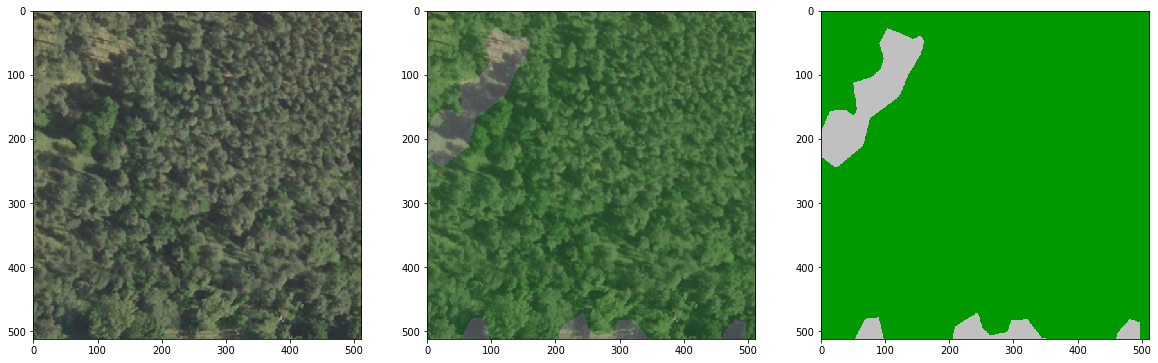

In [86]:
example_id = np.random.randint(0, len(dataset))
# example_id = 10193
print(example_id)

img, mask = dataset.get_sample(example_id)

print(list(map(lambda e: dataset.labels_names[e], np.unique(mask))))

mask = LandcoverAI.apply_colors2mask(mask)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))


ax1.imshow(img)

ax2.imshow(img)
ax2.imshow(mask, alpha = .2)

ax3.imshow(mask,)

## Get the only pictures with forests

In [183]:
class LandcoverAI_OneClass(LandcoverAI):
    
    def __init__(self, class_: int = 2, min_area: float = .05,  keep_in_memory = False):
        
        super(LandcoverAI_OneClass, self).__init__(keep_in_memory = keep_in_memory)
        
        self.min_area = min_area
        self.class_ = class_
        
        self.load_or_generate_data()
        
        self.__filter_classes()
        
        self.train_labels.clear()
        self.val_labels.clear()
        self.test_labels.clear()
        
    
    @staticmethod
    def remove_all_except(mask: np.ndarray, class_: int) -> np.ndarray:
        mask[np.where(mask != class_)] = 0 
        mask[np.where(mask == class_)] = 1 
        return mask
        
        
    def __filter_classes(self):
        for i in tqdm_notebook(range(len(self)-1, -1, -1), desc = "Filtering.."):
            _, mask = self.get_sample(i)
                
            mask = mask[:,:,0]
            mask = LandcoverAI_OneClass.remove_all_except(mask.copy(), self.class_)
            
            ratio = len(np.where(mask)[0]) / (mask.shape[0]*mask.shape[1])
            
            if ratio < self.min_area:
                self.masks.pop(i)
                self.imgs.pop(i)

In [184]:
forest_dataset = LandcoverAI_OneClass(min_area = .05)

In [185]:
len(dataset), len(forest_dataset)

(10674, 6497)

## Choosing best place for removing

Best is the place where the forest has bigger dencity. If it is equal everywhhere - we choose the place closer to the pictures center

In [241]:
from scipy.signal import sepfir2d
from typing import Tuple

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


def get_best_delete_place(mask: np.ndarray, window_size: Tuple[int, int], padd: int) -> Tuple[Tuple[int, int], np.ndarray]:
    """
    Get most dence place in the mask with forest. There we apply miss box.
    :param mask: input mask;
    :param window_size: size of window we gonna delete from the image;
    :param padd: distance from mask's border after which we can delete the window. 
    """
    if len(mask.shape) > 2:
        mask = mask[:,:,0]
    # make zero padding
    mask[:padd, :] = 0
    mask[-padd:, :] = 0
    mask[:, :padd] = 0
    mask[:, -padd:] = 0
    
    # do convolution with separable filter
    convolved = sepfir2d(mask, np.ones(window_size[0]), np.ones(window_size[1]))
    
    # make small prioryty in center
    g = gaussian(np.linspace(-1, 1, mask.shape[0]), 0, 40)
    g2d = g.reshape(-1, 1) @ g.reshape(1, -1)
    convolved += g2d
    
    pick_point = np.unravel_index(convolved.argmax(), convolved.shape)
    
    return pick_point, convolved

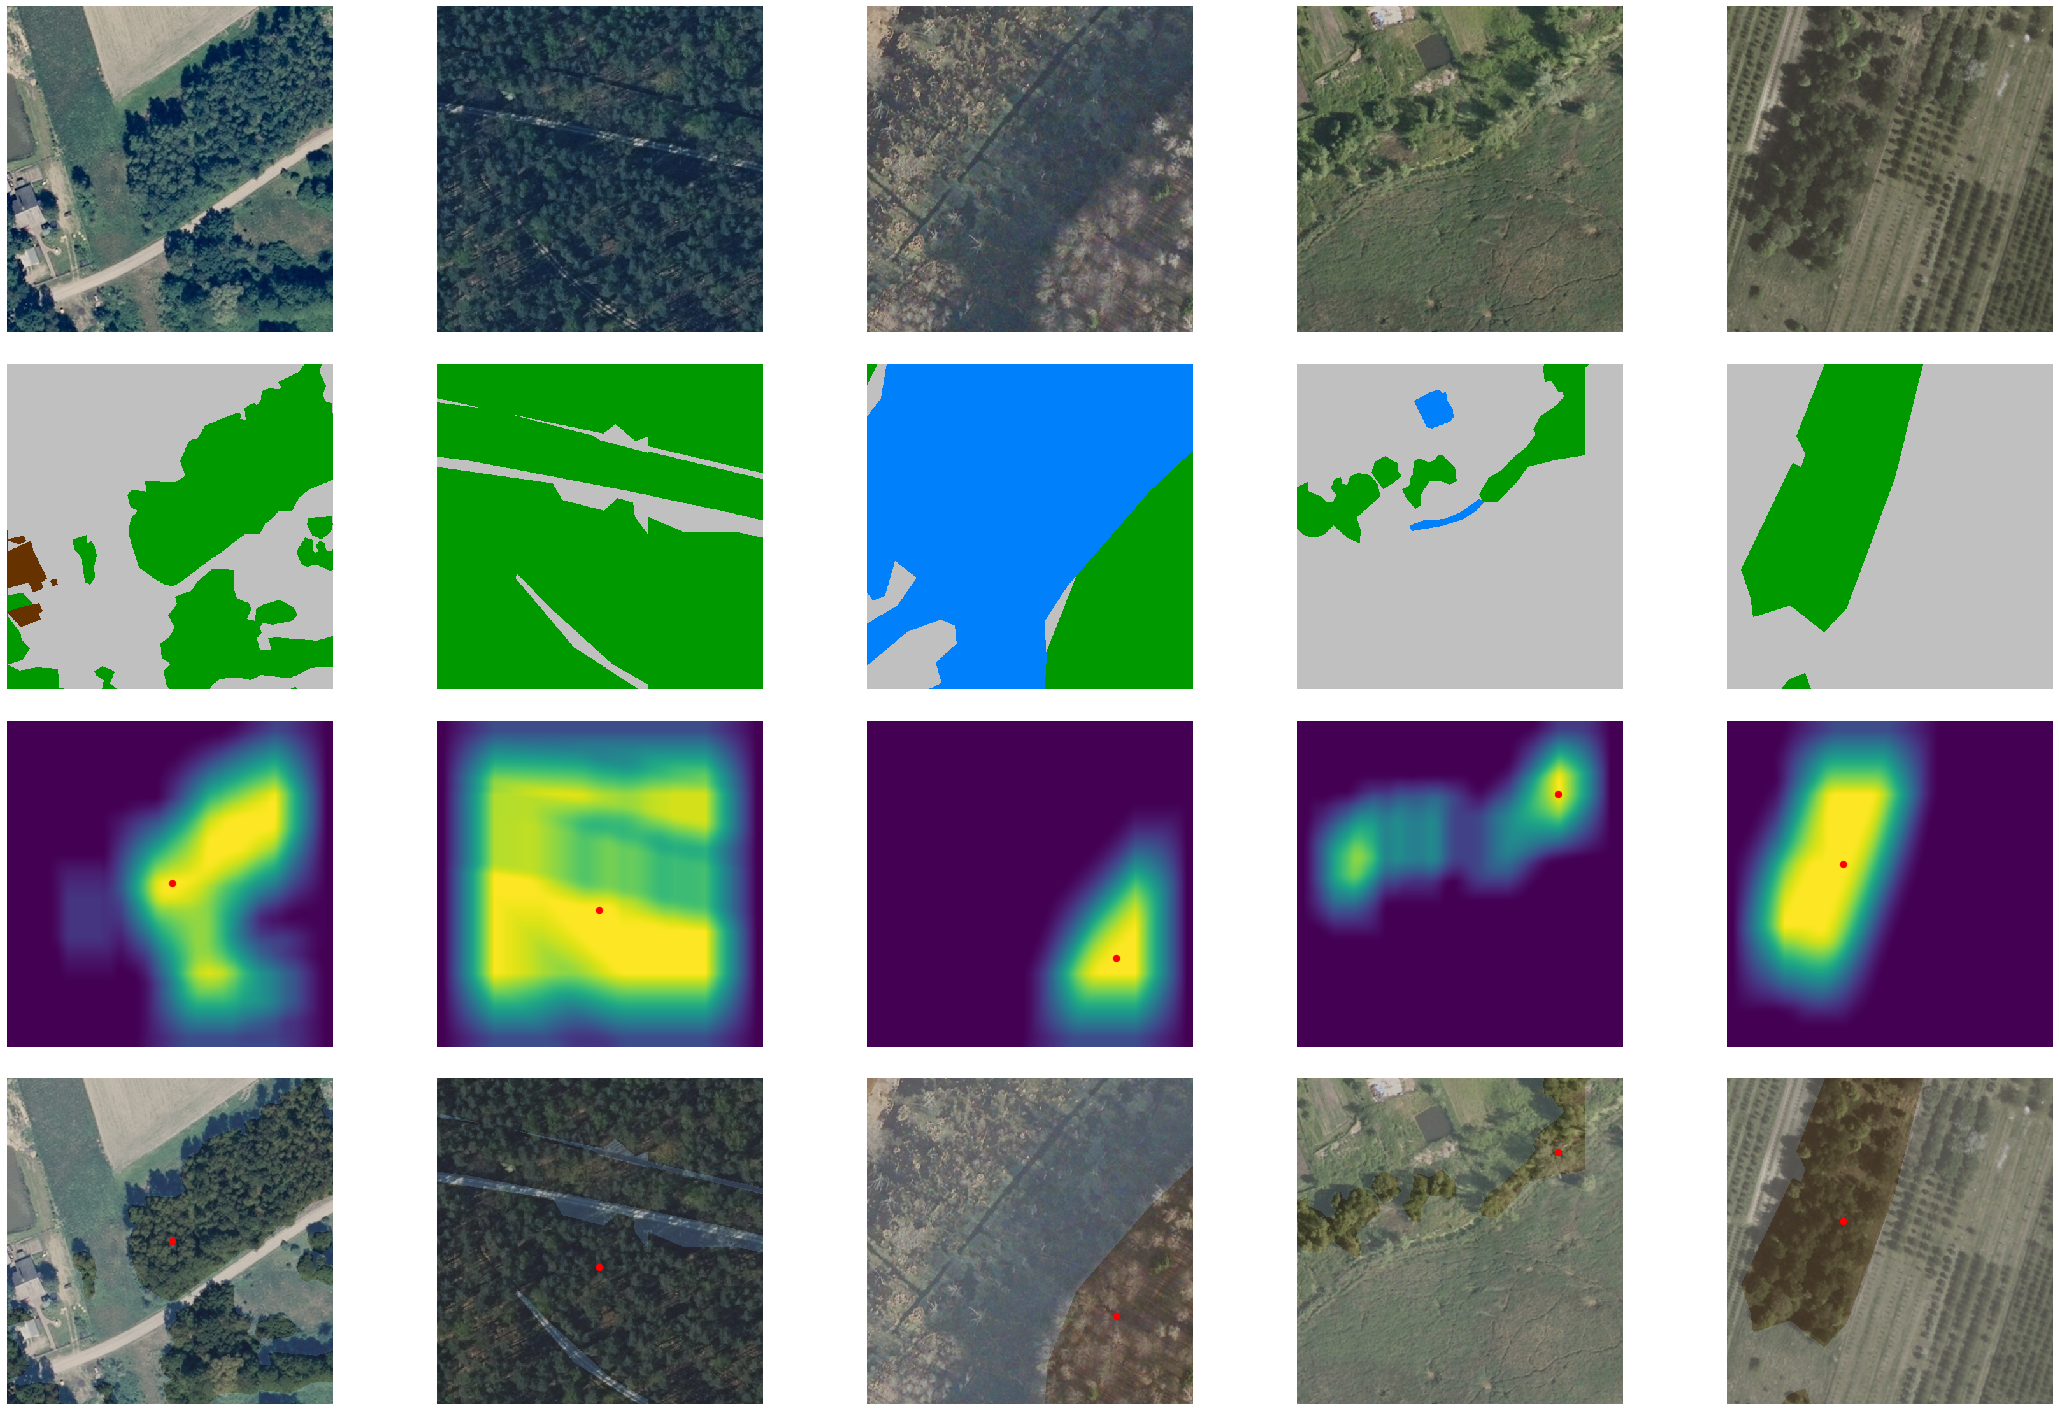

In [254]:
fig, axes = plt.subplots(4, 5, figsize=(30, 20))
fig.tight_layout()

for i in range(5):
    idx = np.random.randint(0, len(forest_dataset))
    img, mask = forest_dataset.get_sample(idx)
    
    axes[0,i].imshow(img)
    axes[0,i].set_axis_off()
    
    axes[1,i].imshow(forest_dataset.apply_colors2mask(mask.copy()))
    axes[1,i].set_axis_off()
    
    mask = LandcoverAI_OneClass.remove_all_except(mask, 2)
    yx , convolved = get_best_delete_place(mask.astype(float), (81, 131), 50)
    axes[2,i].imshow(convolved)
    axes[2,i].scatter(*yx[::-1], c = 'r', s = 40)
    axes[2,i].set_axis_off()
    
    
    axes[3,i].imshow(img)
    axes[3,i].imshow(forest_dataset.apply_colors2mask(mask.copy()), alpha = .2)
    axes[3,i].scatter(*yx[::-1], c = 'r', s = 40)
    axes[3,i].set_axis_off()


## Replacing forest with empty box


In [244]:
def crop_masked_box(img: np.ndarray, mask: np.ndarray, 
             center: Tuple[int, int], box_size: Tuple[int, int]) -> Tuple[np.ndarray, np.ndarray]:
    box_mask = np.zeros_like(mask)

    yc, xc = center
    box_mask[yc - box_size[0]//2 : yc + box_size[0] // 2, 
             xc - box_size[1]//2 : xc + box_size[1] // 2] = 1

    intersection = mask * box_mask
    
    img[np.where(intersection)] = 0
    
    return img, intersection

0
1
2
3
4


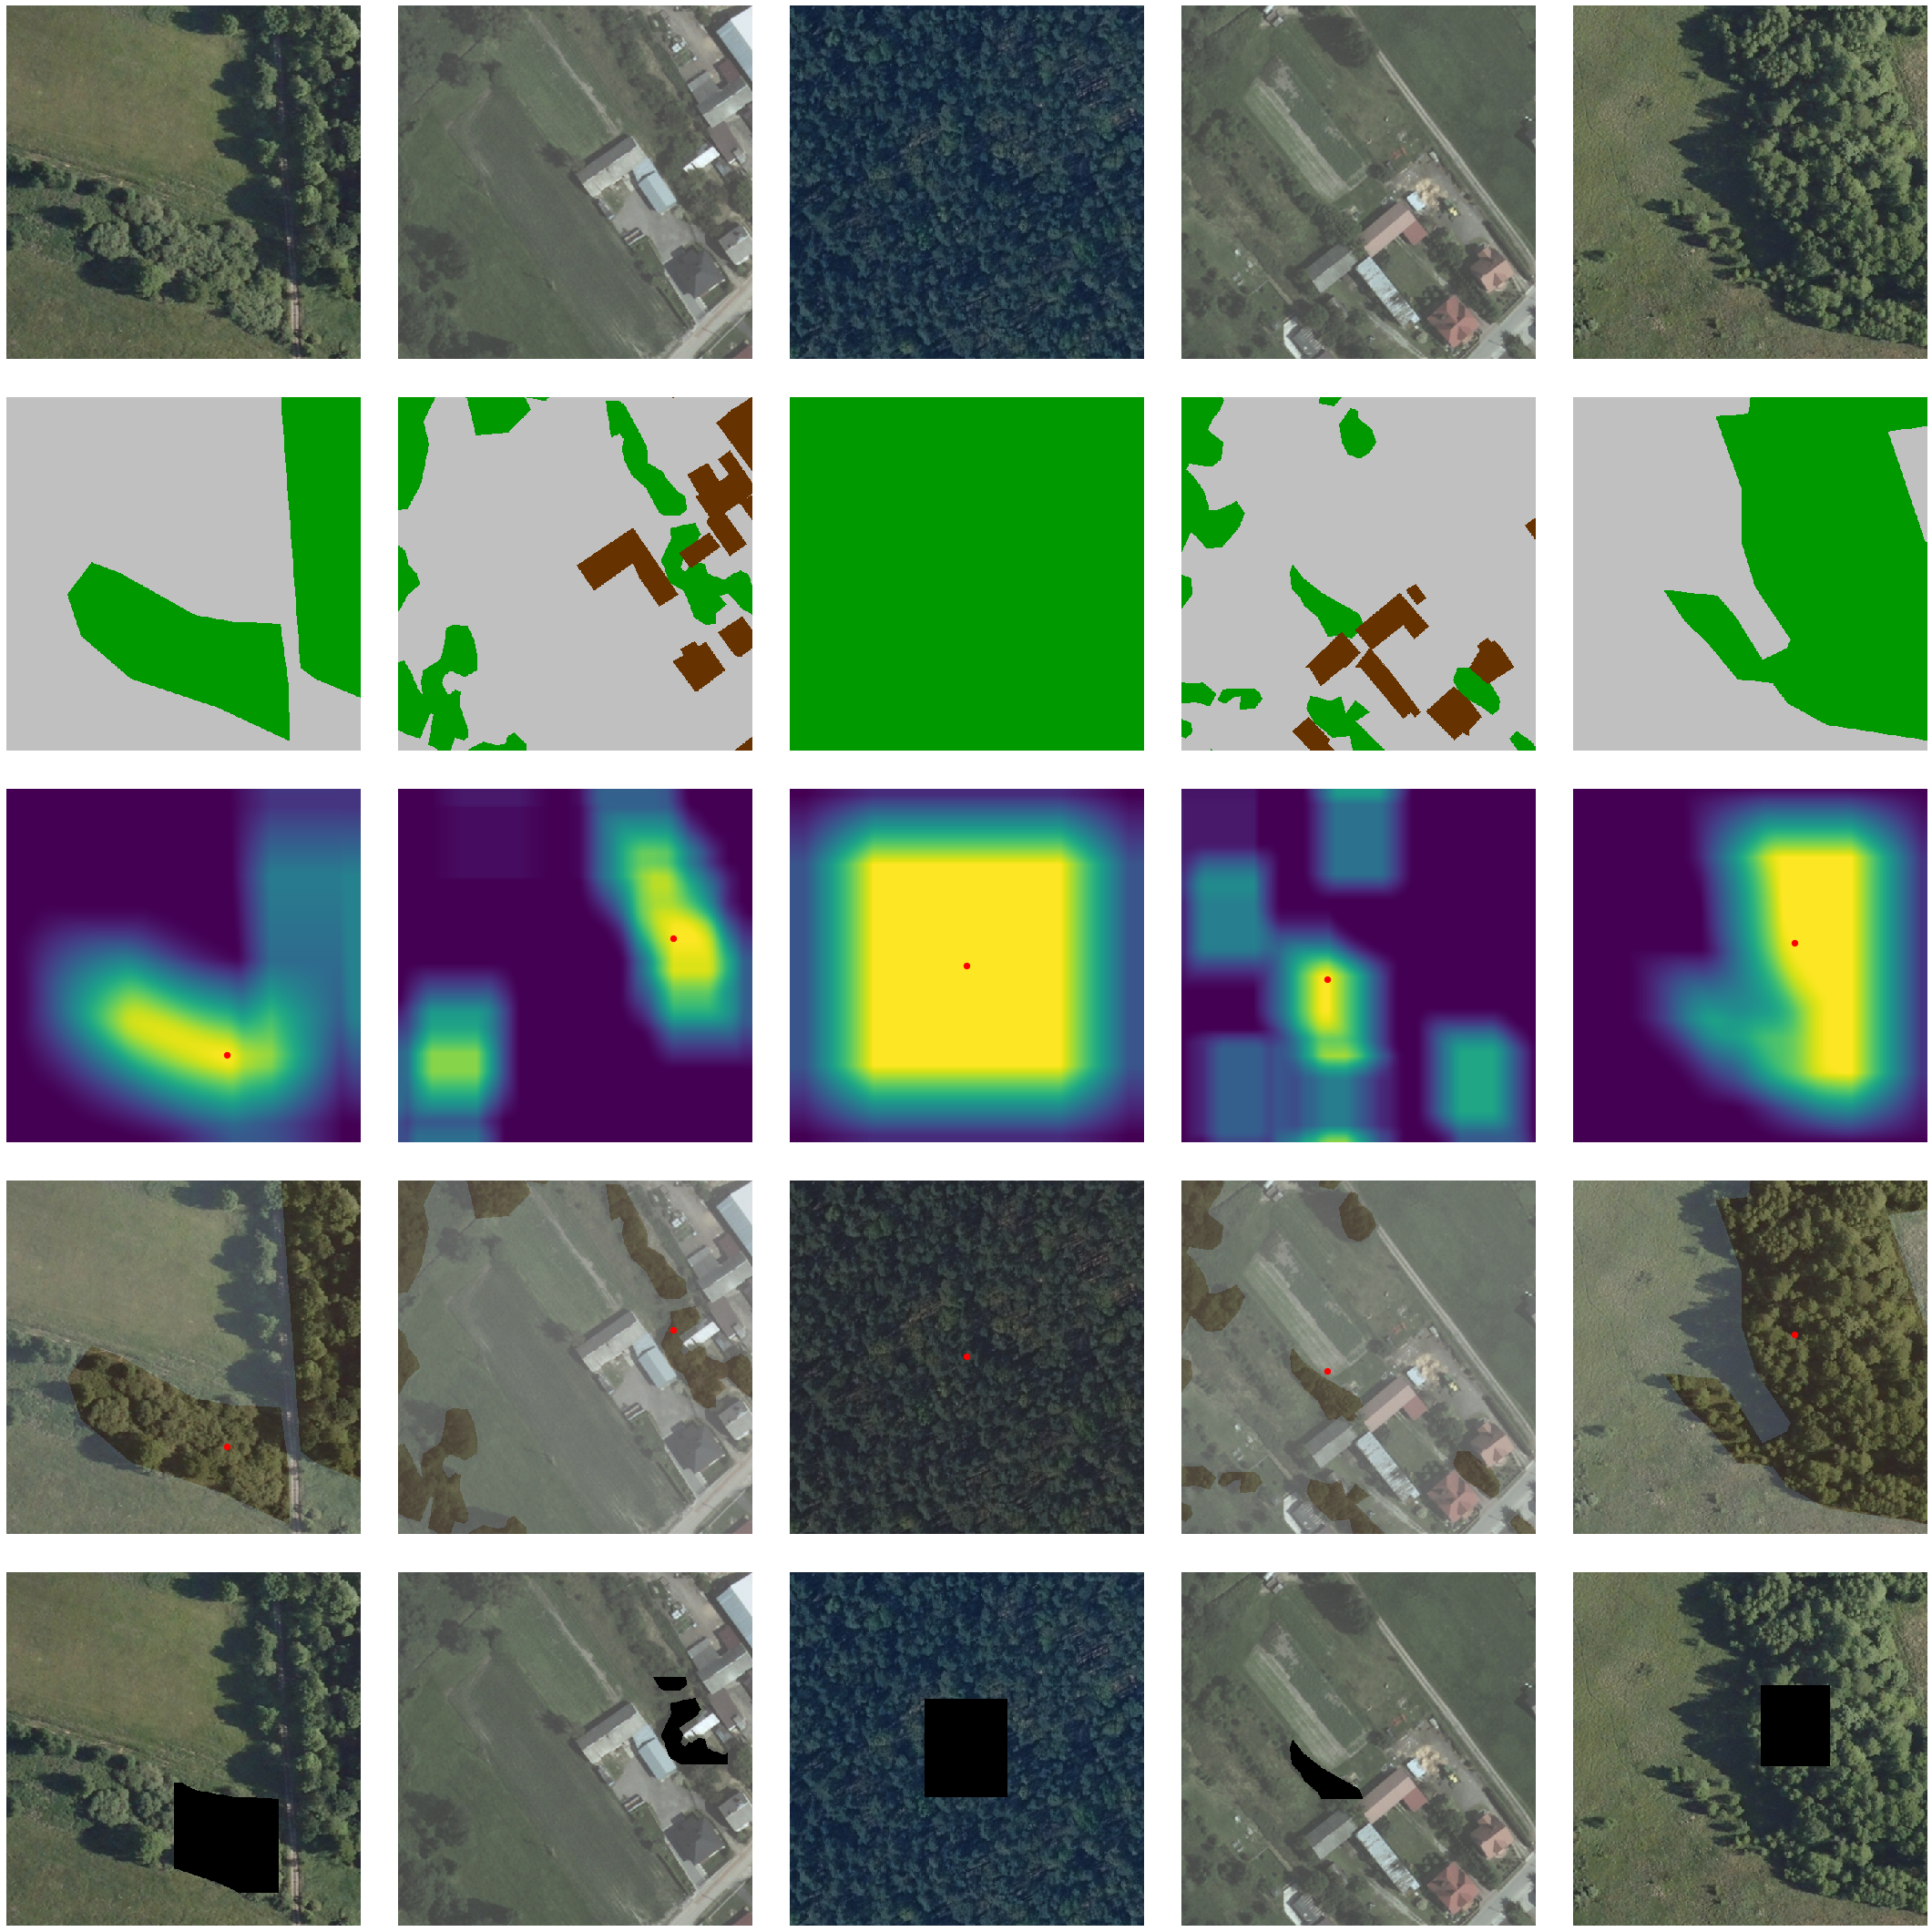

In [255]:
fig, axes = plt.subplots(5, 5, figsize=(30, 30))
fig.tight_layout()

for i in range(5):
    box_size = np.random.choice(np.arange(101, 160, 2), replace = True, size = 2)
    
    
    idx = np.random.randint(0, len(forest_dataset))
    img, mask = forest_dataset.get_sample(idx)
    
    axes[0,i].imshow(img)
    axes[0,i].set_axis_off()
    
    axes[1,i].imshow(forest_dataset.apply_colors2mask(mask.copy()))
    axes[1,i].set_axis_off()
    
    mask = LandcoverAI_OneClass.remove_all_except(mask, 2)
    yx , convolved = get_best_delete_place(mask.astype(float), box_size, 50)
    axes[2,i].imshow(convolved)
    axes[2,i].scatter(*yx[::-1], c = 'r', s = 40)
    axes[2,i].set_axis_off()
    
    
    axes[3,i].imshow(img)
    axes[3,i].imshow(forest_dataset.apply_colors2mask(mask.copy()), alpha = .2)
    axes[3,i].scatter(*yx[::-1], c = 'r', s = 40)
    axes[3,i].set_axis_off()
    
    img, _ = crop_masked_box(img, mask, yx, box_size)
    axes[4,i].imshow(img)
    axes[4,i].set_axis_off()
